In [ ]:
import os
import json

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model

In [ ]:
drive.mount("/content/drive")
sns.set_theme()

Mounted at /content/drive


In [ ]:
images_path = "/content/drive/MyDrive/Datasets/Brain Cancer MRI Simple"

images = []
labels = []

encoded = {"yes" : 1, "no" : 0}

SIZE = 256

for folder_dir in os.scandir(images_path):
  category = folder_dir.path.split("/")[-1]

  for image_dir in os.scandir(folder_dir.path):
    image = cv2.imread(image_dir.path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SIZE, SIZE))

    images.append(image)
    labels.append(encoded[category])

images = np.array(images)
labels = np.array(labels)

images = images / 255.0

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, random_state=42, shuffle=True, stratify=labels)

In [ ]:
labels.shape

(253,)

In [ ]:
pd.Series(labels).value_counts()

1    155
0     98
dtype: int64

In [ ]:
test_samples_grouped = {
    0: [],
    1: []
}

for sample, label in zip(X_test, Y_test):
  test_samples_grouped[label].append(sample)

YES_images = test_samples_grouped[1][:4]
NO_images = test_samples_grouped[0][:4]

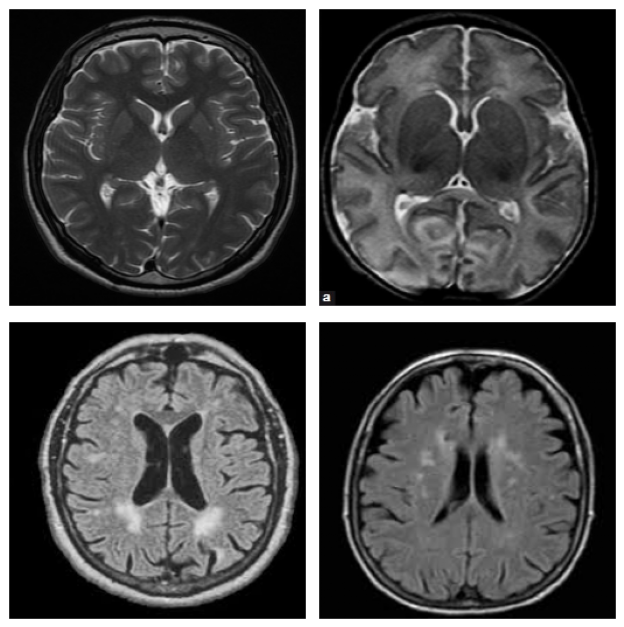

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=80)

k = 0

for i in range(2):
  for j in range(2):
    axs[i][j].get_xaxis().set_ticks([])
    axs[i][j].get_yaxis().set_ticks([])
    axs[i][j].imshow(NO_images[k])
    k += 1

fig.tight_layout()

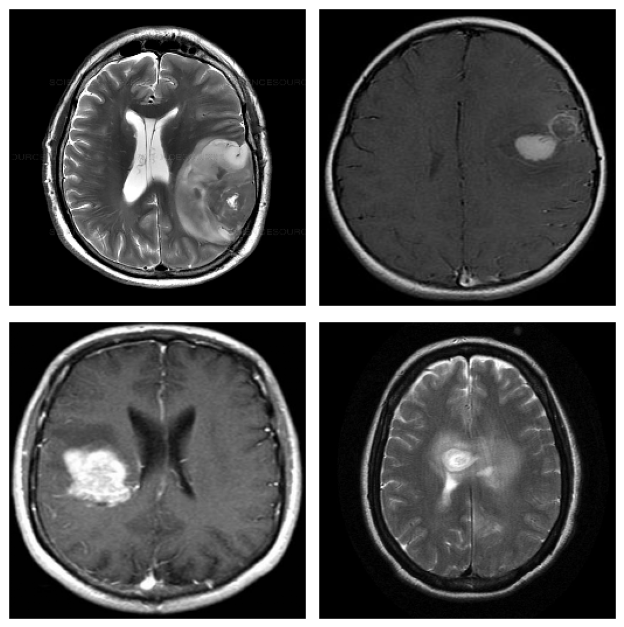

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=80)

k = 0

for i in range(2):
  for j in range(2):
    axs[i][j].get_xaxis().set_ticks([])
    axs[i][j].get_yaxis().set_ticks([])
    axs[i][j].imshow(YES_images[k])
    k += 1

fig.tight_layout()

In [ ]:
class HTLCv1:
    def __init__(self, feature_model="VGG16", cluster_model="KMeans", input_shape=(SIZE, SIZE, 3), n_clusters=2):
        if feature_model == "VGG16":
            self.feature_model = feature_model
            base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")

        elif feature_model == "VGG19":
            self.feature_model = feature_model
            base_model = VGG19(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")

        elif feature_model == "InceptionV3":
            self.feature_model = feature_model
            base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")

        elif feature_model == "ResNet50":
            self.feature_model = feature_model
            base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")

        else:
            self.feature_model = None
            base_model = None
            raise Exception("Invalid feature model. Choose one from this [VGG16, VGG19, InceptionV3, ResNet50]")
        
        if cluster_model == "KMeans":
            self.cluster_model = cluster_model
            self.clustering = KMeans(n_clusters=n_clusters)

        elif cluster_model == "Agglomerative":
            self.cluster_model = cluster_model
            self.clustering = AgglomerativeClustering(n_clusters=n_clusters)

        else:
            self.cluster_model = None
            self.clustering = None
            raise Exception("Invalid clustering model. Choose one from this [KMeans, Agglomerative]")

        for layer in base_model.layers:
            layer.trainable = False

        self.base = Sequential([
            base_model, 
            Flatten(name="addon_flatten_1"),
            Dropout(0.25, name="addon_dropout_1"),
            Dense(200, activation="relu", name="addon_dense_1"),
            Dense(100, activation="relu", name="addon_dense_2"),
            Dense(50,  activation="relu", name="addon_dense_3"), 
            Dense(1,   activation="sigmoid", name="addon_output")
        ])

        self.extractor = Model(inputs=self.base.input, outputs=self.base.get_layer("addon_dense_3").output)
    
    def get_features(self, X):
        return self.extractor.predict(X)

    def train(self, X, y, batch_size=16, epochs=100, verbose=0):
        self.base.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        self.base_history = self.base.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=verbose)

        features = self.extractor.predict(X)

        self.clustering.fit(features)
  
    def predict(self, X):
        features = self.extractor.predict(X)

        if self.cluster_model == "KMeans":
            clusters = self.clustering.predict(features)
        
        if self.cluster_model == "Agglomerative":
            clusters = self.clustering.fit_predict(features)

        return clusters
  
    def evaluate(self, X, y):
        extractor_loss, extractor_accuracy = self.base.evaluate(X, y, verbose=0)
        features = self.extractor.predict(X)
        
        if self.cluster_model == "KMeans":
            clusters = self.clustering.predict(features)
        
        if self.cluster_model == "Agglomerative":
            clusters = self.clustering.fit_predict(features)
    
        return {
            "loss": f"{extractor_loss}",
            "accuracy": f"{extractor_accuracy}",
            "silhouette score" : f"{silhouette_score(features, clusters)}"
        }

In [ ]:
# feature_models = ["VGG16", "VGG19", "InceptionV3", "ResNet50"]
# cluster_models = ["KMeans", "Agglomerative"]

In [ ]:
def plot_accuracy(data):
    plt.plot(data, label="Training")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

#### VGG16 + K-MEANS

In [ ]:
model_1 = HTLCv1(feature_model="VGG16", cluster_model="KMeans" ,n_clusters=2, input_shape=(SIZE, SIZE, 3))
model_1.train(X_train, Y_train, verbose=0, epochs=50)

print("Train data evaluation:", model_1.evaluate(X_train, Y_train))
print("Test data evaluation:",  model_1.evaluate(X_test, Y_test))

58900480/58889256 [==============================] - 0s 0us/step
Train data evaluation: {'loss': '0.2917097508907318', 'accuracy': '0.8518518805503845', 'silhouette score': '0.6234524250030518'}
Test data evaluation: {'loss': '0.6897031664848328', 'accuracy': '0.71875', 'silhouette score': '0.5754454731941223'}


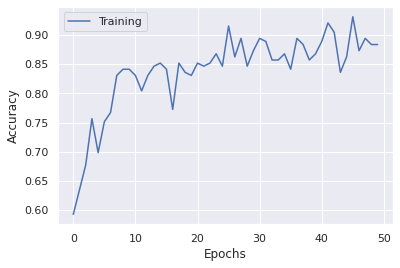

In [ ]:
plot_accuracy(model_1.base_history.history['accuracy'])

#### VGG16 + Agglomerative

In [ ]:
model_2 = HTLCv1(feature_model="VGG16", cluster_model="Agglomerative", n_clusters=2, input_shape=(SIZE, SIZE, 3))
model_2.train(X_train, Y_train, verbose=0, epochs=50)

print("Train data evaluation:", model_2.evaluate(X_train, Y_train))
print("Test data evaluation:",  model_2.evaluate(X_test, Y_test))

Train data evaluation: {'loss': '0.1529160439968109', 'accuracy': '0.9365079402923584', 'silhouette score': '0.5862286686897278'}
Test data evaluation: {'loss': '0.5106334686279297', 'accuracy': '0.8125', 'silhouette score': '0.4843689799308777'}


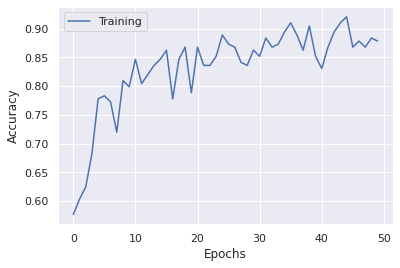

In [ ]:
plot_accuracy(model_2.base_history.history['accuracy'])

#### VGG19 + K-MEANS

In [ ]:
model_3 = HTLCv1(feature_model="VGG19", cluster_model="KMeans", n_clusters=2, input_shape=(SIZE, SIZE, 3))
model_3.train(X_train, Y_train, verbose=0, epochs=50)

print("Train data evaluation:", model_3.evaluate(X_train, Y_train))
print("Test data evaluation:",  model_3.evaluate(X_test, Y_test))

80150528/80134624 [==============================] - 0s 0us/step
Train data evaluation: {'loss': '0.2128981500864029', 'accuracy': '0.9100528955459595', 'silhouette score': '0.600573718547821'}
Test data evaluation: {'loss': '0.36019670963287354', 'accuracy': '0.796875', 'silhouette score': '0.5211308002471924'}


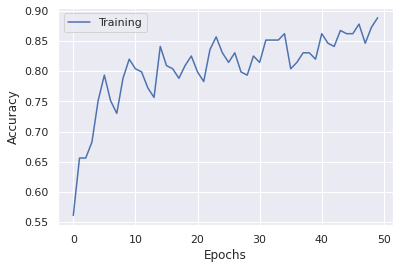

In [ ]:
plot_accuracy(model_3.base_history.history['accuracy'])

#### VGG19 + Agglomerative

In [ ]:
model_4 = HTLCv1(feature_model="VGG19", cluster_model="Agglomerative", n_clusters=2, input_shape=(SIZE, SIZE, 3))
model_4.train(X_train, Y_train, verbose=0, epochs=50)

print("Train data evaluation:", model_4.evaluate(X_train, Y_train))
print("Test data evaluation:",  model_4.evaluate(X_test, Y_test))

Train data evaluation: {'loss': '0.24043172597885132', 'accuracy': '0.8941798806190491', 'silhouette score': '0.5982232689857483'}
Test data evaluation: {'loss': '0.37939631938934326', 'accuracy': '0.8125', 'silhouette score': '0.48949795961380005'}


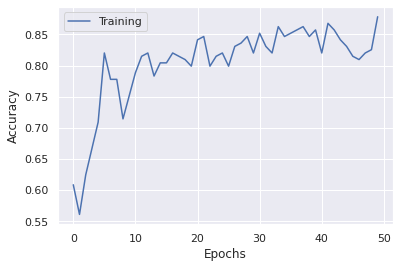

In [ ]:
plot_accuracy(model_4.base_history.history['accuracy'])

#### InceptionV3 + K-MEANS

In [ ]:
model_5 = HTLCv1(feature_model="InceptionV3", cluster_model="KMeans", n_clusters=2, input_shape=(SIZE, SIZE, 3))
model_5.train(X_train, Y_train, verbose=0, epochs=20)

print("Train data evaluation:", model_5.evaluate(X_train, Y_train))
print("Test data evaluation:",  model_5.evaluate(X_test, Y_test))

87924736/87910968 [==============================] - 0s 0us/step
Train data evaluation: {'loss': '0.002221208531409502', 'accuracy': '1.0', 'silhouette score': '0.7642869353294373'}
Test data evaluation: {'loss': '0.45592889189720154', 'accuracy': '0.890625', 'silhouette score': '0.6588547825813293'}


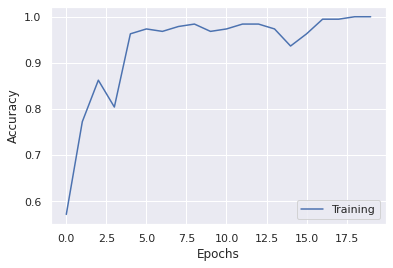

In [ ]:
plot_accuracy(model_5.base_history.history['accuracy'])

#### InceptionV3 + Agglomerative

In [ ]:
model_6 = HTLCv1(feature_model="InceptionV3", cluster_model="Agglomerative", n_clusters=2, input_shape=(SIZE, SIZE, 3))
model_6.train(X_train, Y_train, verbose=0, epochs=20)

print("Train data evaluation:", model_6.evaluate(X_train, Y_train))
print("Test data evaluation:",  model_6.evaluate(X_test, Y_test))

Train data evaluation: {'loss': '0.0020718767773360014', 'accuracy': '1.0', 'silhouette score': '0.7298523187637329'}
Test data evaluation: {'loss': '0.5105323195457458', 'accuracy': '0.890625', 'silhouette score': '0.6215686798095703'}


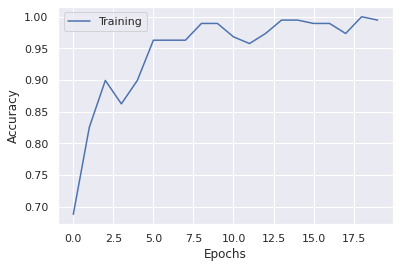

In [ ]:
plot_accuracy(model_6.base_history.history['accuracy'])

#### ResNet50 + K-MEANS

In [ ]:
model_7 = HTLCv1(feature_model="ResNet50", cluster_model="KMeans", n_clusters=2, input_shape=(SIZE, SIZE, 3))
model_7.train(X_train, Y_train, verbose=0, epochs=200)

print("Train data evaluation:", model_7.evaluate(X_train, Y_train))
print("Test data evaluation:",  model_7.evaluate(X_test, Y_test))

94781440/94765736 [==============================] - 0s 0us/step
Train data evaluation: {'loss': '0.2704404294490814', 'accuracy': '0.8941798806190491', 'silhouette score': '0.5447300672531128'}
Test data evaluation: {'loss': '0.7246209383010864', 'accuracy': '0.75', 'silhouette score': '0.3916289806365967'}


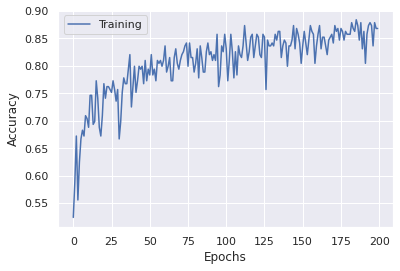

In [ ]:
plot_accuracy(model_7.base_history.history['accuracy'])

#### ResNet50 + Agglomerative

In [ ]:
model_8 = HTLCv1(feature_model="ResNet50", cluster_model="Agglomerative", n_clusters=2, input_shape=(SIZE, SIZE, 3))
model_8.train(X_train, Y_train, verbose=0, epochs=200)

print("Train data evaluation:", model_8.evaluate(X_train, Y_train))
print("Test data evaluation:",  model_8.evaluate(X_test, Y_test))

Train data evaluation: {'loss': '0.2719824016094208', 'accuracy': '0.8941798806190491', 'silhouette score': '0.5319321751594543'}
Test data evaluation: {'loss': '0.6781002283096313', 'accuracy': '0.703125', 'silhouette score': '0.46962153911590576'}


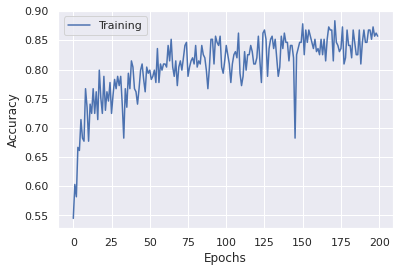

In [ ]:
plot_accuracy(model_8.base_history.history['accuracy'])

In [ ]:
model = Sequential([
  base_model, 
  Flatten(),
  Dropout(0.25),
  Dense(200, activation="relu"),
  Dense(100, activation="relu"),
  Dense(50, activation="relu"), 
  Dense(4, activation="softmax")
])